In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [59]:
link = "https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv"

In [60]:
df1 = pd.read_csv(link)

In [61]:
df = df1.copy()

In [62]:
df.shape

(1462, 9)

In [63]:
df.head(3)

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1


In [64]:
df.isnull().sum()

lead_source                 128
industry                    134
number_of_courses_viewed      0
annual_income               181
employment_status           100
location                     63
interaction_count             0
lead_score                    0
converted                     0
dtype: int64

In [65]:
categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)
categorical_columns

['lead_source', 'industry', 'employment_status', 'location']

In [66]:
df[categorical_columns].isnull().sum()

lead_source          128
industry             134
employment_status    100
location              63
dtype: int64

In [67]:
df[categorical_columns] = df[categorical_columns].fillna('NA')

In [68]:
df[categorical_columns].isnull().sum()

lead_source          0
industry             0
employment_status    0
location             0
dtype: int64

In [69]:
df.annual_income = df.annual_income.fillna(0.0)

In [70]:
df.isnull().sum()

lead_source                 0
industry                    0
number_of_courses_viewed    0
annual_income               0
employment_status           0
location                    0
interaction_count           0
lead_score                  0
converted                   0
dtype: int64

In [71]:
list(df.columns)

['lead_source',
 'industry',
 'number_of_courses_viewed',
 'annual_income',
 'employment_status',
 'location',
 'interaction_count',
 'lead_score',
 'converted']

In [72]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [73]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.converted.values
y_val = df_val.converted.values
y_test = df_test.converted.values

del df_train['converted']
del df_val['converted']
del df_test['converted']

In [74]:
categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)
categorical_columns

['lead_source', 'industry', 'employment_status', 'location']

In [75]:
numerical_columns = ['number_of_courses_viewed', 'annual_income', 'interaction_count', 'lead_score']
numerical_columns

['number_of_courses_viewed',
 'annual_income',
 'interaction_count',
 'lead_score']

In [76]:
df_train[numerical_columns]

,number_of_courses_viewed,annual_income,interaction_count,lead_score
0,2,95543.0,3,0.78
1,1,54924.0,6,0.39
2,2,77352.0,2,0.22
3,2,34600.0,2,0.31
4,0,43615.0,2,0.01
...,...,...,...,...
871,5,67314.0,2,0.87
872,6,63996.0,4,0.92
873,1,73702.0,2,0.55
874,1,93341.0,4,0.99


In [77]:
from sklearn.metrics import roc_auc_score

for val in numerical_columns:
    print(val)
    score = roc_auc_score(y_train, df_train[val])
    print('AUC', round(score,3))
    print()

number_of_courses_viewed
AUC 0.764

annual_income
AUC 0.552

interaction_count
AUC 0.738

lead_score
AUC 0.614



In [78]:
numerical_columns, categorical_columns

(['number_of_courses_viewed',
  'annual_income',
  'interaction_count',
  'lead_score'],
 ['lead_source', 'industry', 'employment_status', 'location'])

#### Sol 1: The numerical variable  with has the highest AUC is number_of_courses_viewed with AUC 0.764 .

In [98]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical_columns + numerical_columns].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'liblinear'
,max_iter,1000
,multi_class,'deprecated'


In [101]:
val_dict = df_val[categorical_columns + numerical_columns].to_dict(orient='records')
X_val = dv.transform(val_dict)
y_pred = model.predict_proba(X_val)[:, 1]

In [102]:
val_auc = roc_auc_score(y_val, y_pred)
round(val_auc,3)

0.817

#### Sol 2: The AUC of this model on the validation dataset is 0.817 and the closest to this is 0.72 <<<



In [103]:
scores = []

thresholds = np.linspace(0, 1, 101)

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    scores.append((t, tp, fp, fn, tn))

In [108]:
columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
df_scores = pd.DataFrame(scores, columns=columns)

df_scores['precision'] = df_scores.tp / (df_scores.tp + df_scores.fp)
df_scores['recall'] = df_scores.tp / (df_scores.tp + df_scores.fn)

In [ ]:
df_scores['prec-recall']=df_scores.precision-df_scores.recall

In [143]:
df_scores[::2]

,threshold,tp,fp,fn,tn,precision,recall,prec-recall,precision_recall_difference,f1
0,0.00,171,122,0,0,0.583618,1.000000,-0.416382,0.416382,0.737069
2,0.02,171,122,0,0,0.583618,1.000000,-0.416382,0.416382,0.737069
4,0.04,171,122,0,0,0.583618,1.000000,-0.416382,0.416382,0.737069
6,0.06,171,122,0,0,0.583618,1.000000,-0.416382,0.416382,0.737069
8,0.08,171,122,0,0,0.583618,1.000000,-0.416382,0.416382,0.737069
10,0.10,171,122,0,0,0.583618,1.000000,-0.416382,0.416382,0.737069
12,0.12,171,122,0,0,0.583618,1.000000,-0.416382,0.416382,0.737069
14,0.14,171,122,0,0,0.583618,1.000000,-0.416382,0.416382,0.737069
16,0.16,171,122,0,0,0.583618,1.000000,-0.416382,0.416382,0.737069
18,0.18,171,122,0,0,0.583618,1.000000,-0.416382,0.416382,0.737069


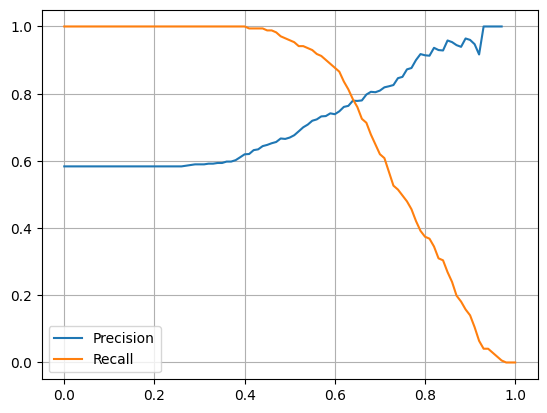

In [144]:
plt.plot(df_scores.threshold, df_scores['precision'], label='Precision')
plt.plot(df_scores.threshold, df_scores['recall'], label='Recall')
plt.legend()
plt.grid(True)
plt.show()

#### Sol 3: The threshold at which precision and recall curves intersect is 0.545 (considering it it close to 0.64 from above values)




In [145]:
df_scores['f1']=(2*df_scores.precision*df_scores.recall)/(df_scores.precision+df_scores.recall)

In [146]:
df_scores[::2]

,threshold,tp,fp,fn,tn,precision,recall,prec-recall,precision_recall_difference,f1
0,0.00,171,122,0,0,0.583618,1.000000,-0.416382,0.416382,0.737069
2,0.02,171,122,0,0,0.583618,1.000000,-0.416382,0.416382,0.737069
4,0.04,171,122,0,0,0.583618,1.000000,-0.416382,0.416382,0.737069
6,0.06,171,122,0,0,0.583618,1.000000,-0.416382,0.416382,0.737069
8,0.08,171,122,0,0,0.583618,1.000000,-0.416382,0.416382,0.737069
10,0.10,171,122,0,0,0.583618,1.000000,-0.416382,0.416382,0.737069
12,0.12,171,122,0,0,0.583618,1.000000,-0.416382,0.416382,0.737069
14,0.14,171,122,0,0,0.583618,1.000000,-0.416382,0.416382,0.737069
16,0.16,171,122,0,0,0.583618,1.000000,-0.416382,0.416382,0.737069
18,0.18,171,122,0,0,0.583618,1.000000,-0.416382,0.416382,0.737069


#### Sol 4: The threshold at which F1 is maximal is 0.54 closed to 0.56






In [ ]:
s